In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ["TRANSFORMERS_CACHE"]="/workspace/cache"
os.environ["HF_DATASETS_CACHE"]="/workspace/cache" 

In [2]:
import torch
from PIL import Image
from transformers import AutoProcessor, SiglipModel, AutoImageProcessor, AutoModel, AutoTokenizer
import faiss
import numpy as np
import datasets
from datasets import load_dataset
from torchvision import transforms
import requests
from tqdm import tqdm
import pickle

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

model = SiglipModel.from_pretrained("google/siglip-base-patch16-224").to(device)
processor = AutoProcessor.from_pretrained("google/siglip-base-patch16-224")
tokenizer = AutoTokenizer.from_pretrained("google/siglip-base-patch16-224")

/root/anaconda3/envs/llava/lib/python3.10/site-packages/transformers/utils/hub.py:123: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/root/anaconda3/envs/llava/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
coyo_dataset = datasets.load_from_disk("/workspace/sea_vl/ALL_DATA_filtered")

In [4]:
sea_vqa = load_dataset('wit543/sea-vqa')
cvqa = load_dataset('afaji/cvqa')['test']

In [5]:
def add_vector(embedding, index):
    vector = embedding.detach().cpu().numpy()
    vector = np.float32(vector)
    faiss.normalize_L2(vector)
    index.add(vector)

def embed_siglip(image):
    with torch.no_grad():
        inputs = processor(images=image, return_tensors="pt").to(device)
        image_features = model.get_image_features(**inputs)
        return image_features

In [51]:
index = faiss.IndexFlatIP(768)

image_openned = []

# read the image and add vector
limit = 1000
count = 0
for elem in tqdm(coyo_dataset):
    url = elem['url']
    try:
        image = Image.open(requests.get(url, stream=True, timeout=3).raw)
        image_openned.append(image)
        clip_features = embed_siglip(image)
        # break
        add_vector(clip_features,index)
    except:
        pass
    count += 1
    if count == limit:
        break

  0%|                                                                | 999/2704068 [12:55<582:34:33,  1.29it/s]


In [54]:
 with open('imageIndex_all_filtered_data.pkl', 'wb') as file: 
    pickle.dump(image_openned, file) 

In [55]:
with open('imageIndex_all_filtered_data.pkl', 'rb') as file: 
    image_openned = pickle.load(file) 

In [56]:
faiss.write_index(index,"siglip_all_filtered_data.index")

In [57]:
index = faiss.read_index("siglip_all_filtered_data.index")

# seavqa

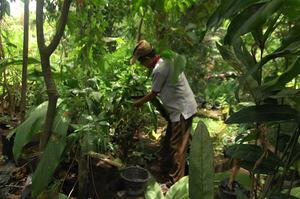

In [42]:
url = sea_vqa['indonesia'][0]['image_path']
image = Image.open(requests.get(url, stream=True).raw)
# images are way too large that make this notebook too large as well
# downscale
width = 300
ratio = (width / float(image.size[0]))
height = int((float(image.size[1]) * float(ratio)))
img = image.resize((width, height), Image.Resampling.LANCZOS)
display(img)

In [43]:
with torch.no_grad():
    inputs = processor(images=image, return_tensors="pt").to(device)
    input_features = model.get_image_features(**inputs)

input_features = input_features.detach().cpu().numpy()
input_features = np.float32(input_features)
faiss.normalize_L2(input_features)
distances, indices = index.search(input_features, 3)

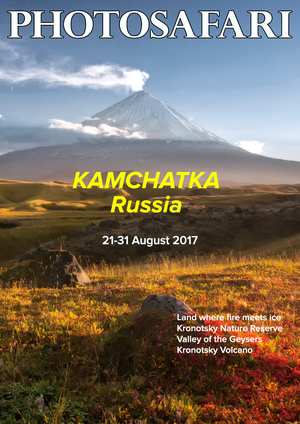

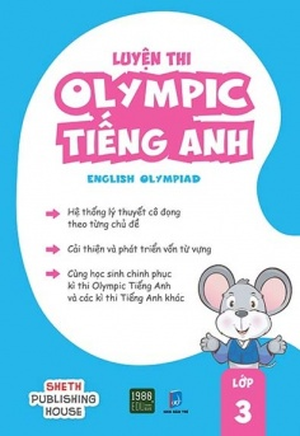

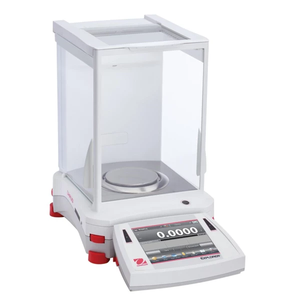

In [44]:
for elem in indices[0]:
    # url = coyo_dataset[int(elem)]['url']
    image = image_openned[int(elem)]
    width = 300
    ratio = (width / float(image.size[0]))
    height = int((float(image.size[1]) * float(ratio)))
    img = image.resize((width, height), Image.Resampling.LANCZOS)
    display(img)

# Back to CLIP

In [45]:
from sentence_transformers import SentenceTransformer

In [46]:
st_model = SentenceTransformer("sentence-transformers/clip-ViT-B-32")

/root/anaconda3/envs/llava/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [48]:
def embed_st(image,index):
    

In [87]:
index = faiss.IndexFlatIP(512)

In [79]:
embeding = st_model.encode(image_openned,return_numpy=True)

/root/anaconda3/envs/llava/lib/python3.10/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [84]:
embeding = embeding / np.linalg.norm(embeding, axis=1)[:, None]

In [88]:
index.train(embeding)

In [89]:
index.add(embeding)

In [90]:
faiss.write_index(index,"clip_all_filtered_data.index")

In [91]:
index = faiss.read_index("clip_all_filtered_data.index")

## test clip again

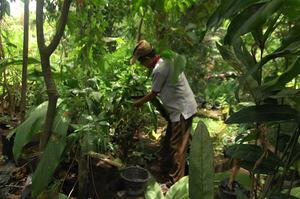

In [92]:
url = sea_vqa['indonesia'][0]['image_path']
image = Image.open(requests.get(url, stream=True).raw)
# images are way too large that make this notebook too large as well
# downscale
width = 300
ratio = (width / float(image.size[0]))
height = int((float(image.size[1]) * float(ratio)))
img = image.resize((width, height), Image.Resampling.LANCZOS)
display(img)

In [94]:
input_features = st_model.encode([image],return_numpy=True)
# input_features = np.float32(input_features)
# faiss.normalize_L2(input_features)
input_features = input_features / np.linalg.norm(input_features, axis=1)[:, None]
distances, indices = index.search(input_features, 3)

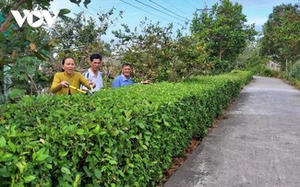

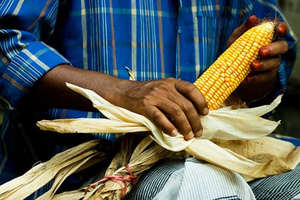

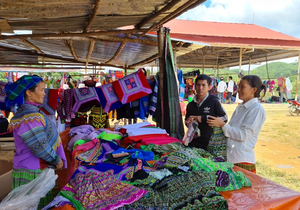

In [95]:
for elem in indices[0]:
    # url = coyo_dataset[int(elem)]['url']
    image = image_openned[int(elem)]
    width = 300
    ratio = (width / float(image.size[0]))
    height = int((float(image.size[1]) * float(ratio)))
    img = image.resize((width, height), Image.Resampling.LANCZOS)
    display(img)